In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [65]:
# get metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Schema & Metadata

This section generates structured metadata for the dataset:
- Dataset size (number of rows and columns)
- For each column: data type, non-null/null counts, number of unique values
- Example values (up to 3 frequent values)
- For numeric columns: min, max, mean
- Per-column memory usage (deep=True)

Notes:
- The code will only display the metadata as output in the notebook.
- No files will be written to disk.

In [66]:
# Generate and display schema metadata (no file output)
import json
import numpy as np
import pandas as pd

# Dataset size
n_rows, n_cols = df.shape
print(f"Rows: {n_rows}, Columns: {n_cols}")

def safe_float(x):
    """Convert to float if possible, else return None (for JSON/printing friendliness)."""
    try:
        return float(x)
    except Exception:
        return None

columns_meta = []
for col in df.columns:
    s = df[col]
    dtype = str(s.dtype)
    non_null = int(s.notna().sum())
    nulls = int(s.isna().sum())
    n_unique = int(s.nunique(dropna=True))
    # Example values (top 3 by frequency)
    examples = (s.dropna()
                  .astype(str)
                  .value_counts()
                  .head(3)
                  .index
                  .tolist())
    # Numeric statistics
    if pd.api.types.is_numeric_dtype(s):
        min_v = safe_float(np.nanmin(s)) if non_null > 0 else None
        max_v = safe_float(np.nanmax(s)) if non_null > 0 else None
        mean_v = safe_float(np.nanmean(s)) if non_null > 0 else None
    else:
        min_v = max_v = mean_v = None
    mem_bytes = int(s.memory_usage(deep=True))
    columns_meta.append({
        "name": col,
        "dtype": dtype,
        "non_null": non_null,
        "nulls": nulls,
        "unique": n_unique,
        "examples": examples,
        "min": min_v,
        "max": max_v,
        "mean": mean_v,
        "memory_bytes": mem_bytes,
    })

meta = {
    "n_rows": int(n_rows),
    "n_cols": int(n_cols),
    "columns": columns_meta,
}

# Display as a table
pd.DataFrame(columns_meta)

Rows: 200, Columns: 5


,name,dtype,non_null,nulls,unique,examples,min,max,mean,memory_bytes
0,CustomerID,int64,200,0,200,"[1, 2, 3]",1.0,200.0,100.50,1732
1,Genre,object,200,0,2,"[Female, Male]",NaN,NaN,NaN,10956
2,Age,int64,200,0,51,"[32, 35, 31]",18.0,70.0,38.85,1732
3,Annual Income (k$),int64,200,0,64,"[54, 78, 60]",15.0,137.0,60.56,1732
4,Spending Score (1-100),int64,200,0,84,"[42, 55, 73]",1.0,99.0,50.20,1732


## Cleaning, Scaling, and Feature Selection

In [67]:
df.drop('CustomerID', axis=1, inplace=True)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [68]:
df.isnull().sum()

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [69]:
# Outlier detection using IsolationForest + LocalOutlierFactor (robust to missing scale_cols)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import numpy as np

# Determine columns to use for outlier detection. Prefer previously computed 'scale_cols'
if 'scale_cols' in globals() and all([c in df.columns for c in scale_cols]):
    detect_cols = scale_cols
else:
    # fall back to numeric columns excluding binary-like columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    binary_like = [c for c in num_cols if df[c].nunique(dropna=True) <= 2]
    detect_cols = [c for c in num_cols if c not in binary_like]
    print('Using fallback numeric columns for outlier detection (first 10):', detect_cols[:10])

if len(detect_cols) == 0:
    raise RuntimeError('No numeric columns available for outlier detection')

# Prepare data for detection: fill NA and scale locally (do not overwrite df columns)
X_out = df[detect_cols].fillna(0).values
X_out_scaled = StandardScaler().fit_transform(X_out)

# Parameters: adjust contamination as needed (fraction of expected outliers)
contamination = 0.05

# Isolation Forest on scaled features
iso = IsolationForest(contamination=contamination, random_state=42)
iso_pred = iso.fit_predict(X_out_scaled)
df['is_outlier_iso'] = (iso_pred == -1)

# Local Outlier Factor (use fit_predict on scaled data)
n_neighbors = min(20, max(5, int(np.sqrt(X_out_scaled.shape[0]))))
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
lof_pred = lof.fit_predict(X_out_scaled)
df['is_outlier_lof'] = (lof_pred == -1)

# Combined rule: mark as outlier only if both methods agree (conservative)
df['is_outlier_combined'] = df['is_outlier_iso'] & df['is_outlier_lof']

# Summary counts
print('IsolationForest outliers:', int(df['is_outlier_iso'].sum()))
print('LOF outliers:', int(df['is_outlier_lof'].sum()))
print('Combined outliers:', int(df['is_outlier_combined'].sum()))

# Drop rows flagged by the conservative combined detector and save the cleaned dataset
n_combined = int(df['is_outlier_combined'].sum())
print(f'Removing {n_combined} combined outlier rows...')
df = df[~df['is_outlier_combined']].reset_index(drop=True)
print('Saved cleaned Preprocessed_Data.csv with', df.shape[0], 'rows and', df.shape[1], 'columns')
# throw away generated columns
df.drop(columns=['is_outlier_combined', 'is_outlier_lof', 'is_outlier_iso'], axis = 1, inplace=True)

Using fallback numeric columns for outlier detection (first 10): ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
IsolationForest outliers: 10
LOF outliers: 10
Combined outliers: 7
Removing 7 combined outlier rows...
Saved cleaned Preprocessed_Data.csv with 193 rows and 7 columns
IsolationForest outliers: 10
LOF outliers: 10
Combined outliers: 7
Removing 7 combined outlier rows...
Saved cleaned Preprocessed_Data.csv with 193 rows and 7 columns


In [70]:
# encoding binary data with 0 (female) and 1 (male)
df['Genre'] = df['Genre'].map({'Female': 0, 'Male': 1})
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,21,15,81
1,0,23,16,77
2,0,31,17,40
3,0,22,17,76
4,0,35,18,6


In [71]:
# handling duplicates
df.duplicated().sum()

np.int64(0)

In [72]:
from sklearn.linear_model import LogisticRegression
X = df.drop('Genre', axis=1)
y = df['Genre']
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.5751
ROC AUC: 0.5016


## Practical Feature Engineering

We add a few interpretable features to better reflect customer profiles:
- Income_per_Age: annual income divided by age
- Spend_to_Income: spending score divided by annual income
- Income bins (quartiles) as one-hot dummies
- Polynomial Features (degree=2), including interactions and non-linear relationships

Note: features are created before scaling; binary/dummy variables will not be scaled later.

In [73]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_features = poly.get_feature_names_out(X.columns)
df_poly = pd.DataFrame(X_poly, columns=poly_features)
for col in df_poly.columns:
    if col not in X.columns:
        df[col] = df_poly[col]
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Age^2,Age Annual Income (k$),Age Spending Score (1-100),Annual Income (k$)^2,Annual Income (k$) Spending Score (1-100),Spending Score (1-100)^2
0,1,21,15,81,441.0,315.0,1701.0,225.0,1215.0,6561.0
1,0,23,16,77,529.0,368.0,1771.0,256.0,1232.0,5929.0
2,0,31,17,40,961.0,527.0,1240.0,289.0,680.0,1600.0
3,0,22,17,76,484.0,374.0,1672.0,289.0,1292.0,5776.0
4,0,35,18,6,1225.0,630.0,210.0,324.0,108.0,36.0


In [74]:
# feature engineering: creating age groups by one hot encoding
bins = [0, 25, 45, 65, 1000]
labels = ['<=24', '25-44', '45-64', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
age_dummies = pd.get_dummies(df['AgeGroup'], prefix='AgeGroup')
df = pd.concat([df, age_dummies], axis=1)
df.drop('AgeGroup', axis=1, inplace=True)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Age^2,Age Annual Income (k$),Age Spending Score (1-100),Annual Income (k$)^2,Annual Income (k$) Spending Score (1-100),Spending Score (1-100)^2,AgeGroup_<=24,AgeGroup_25-44,AgeGroup_45-64,AgeGroup_65+
0,1,21,15,81,441.0,315.0,1701.0,225.0,1215.0,6561.0,True,False,False,False
1,0,23,16,77,529.0,368.0,1771.0,256.0,1232.0,5929.0,True,False,False,False
2,0,31,17,40,961.0,527.0,1240.0,289.0,680.0,1600.0,False,True,False,False
3,0,22,17,76,484.0,374.0,1672.0,289.0,1292.0,5776.0,True,False,False,False
4,0,35,18,6,1225.0,630.0,210.0,324.0,108.0,36.0,False,True,False,False


In [75]:
# Create engineered features before scaling
import numpy as np
import pandas as pd

# Guard against division by zero
eps = 1e-9

if all(col in df.columns for col in ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']):
    df['Income_per_Age'] = df['Annual Income (k$)'] / (df['Age'] + eps)
    df['Spend_to_Income'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] + eps)
    # Income bins (quartiles) -> dummies
    try:
        income_bins = pd.qcut(df['Annual Income (k$)'], q=4, labels=['Q1','Q2','Q3','Q4'])
        income_dummies = pd.get_dummies(income_bins, prefix='IncomeBin')
        df = pd.concat([df, income_dummies], axis=1)
    except Exception as e:
        print('Income binning skipped:', e)
else:
    print('Required base columns not found for feature engineering.')

df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Age^2,Age Annual Income (k$),Age Spending Score (1-100),Annual Income (k$)^2,Annual Income (k$) Spending Score (1-100),Spending Score (1-100)^2,AgeGroup_<=24,AgeGroup_25-44,AgeGroup_45-64,AgeGroup_65+,Income_per_Age,Spend_to_Income,IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,IncomeBin_Q4
0,1,21,15,81,441.0,315.0,1701.0,225.0,1215.0,6561.0,True,False,False,False,0.714286,5.400000,True,False,False,False
1,0,23,16,77,529.0,368.0,1771.0,256.0,1232.0,5929.0,True,False,False,False,0.695652,4.812500,True,False,False,False
2,0,31,17,40,961.0,527.0,1240.0,289.0,680.0,1600.0,False,True,False,False,0.548387,2.352941,True,False,False,False
3,0,22,17,76,484.0,374.0,1672.0,289.0,1292.0,5776.0,True,False,False,False,0.772727,4.470588,True,False,False,False
4,0,35,18,6,1225.0,630.0,210.0,324.0,108.0,36.0,False,True,False,False,0.514286,0.333333,True,False,False,False


In [76]:
# scaling using standard scaler (exclude binary/dummy features)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Select numeric columns with >2 unique values (exclude binary/dummies like Genre or IncomeBin_*)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
binary_like = [c for c in num_cols if df[c].nunique(dropna=True) <= 2]
scale_cols = [c for c in num_cols if c not in binary_like]

df[scale_cols] = scaler.fit_transform(df[scale_cols])
print('Scaled columns:', scale_cols[:10], '... (total', len(scale_cols), ')')
df.head()

Scaled columns: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Age^2', 'Age Annual Income (k$)', 'Age Spending Score (1-100)', 'Annual Income (k$)^2', 'Annual Income (k$) Spending Score (1-100)', 'Spending Score (1-100)^2', 'Income_per_Age'] ... (total 11 )


,Genre,Age,Annual Income (k$),Spending Score (1-100),Age^2,Age Annual Income (k$),Age Spending Score (1-100),Annual Income (k$)^2,Annual Income (k$) Spending Score (1-100),Spending Score (1-100)^2,AgeGroup_<=24,AgeGroup_25-44,AgeGroup_45-64,AgeGroup_65+,Income_per_Age,Spend_to_Income,IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,IncomeBin_Q4
0,1,-1.301255,-1.866777,1.190104,-1.073103,-1.699593,-0.165416,-1.292631,-0.839504,1.262215,True,False,False,False,-1.137799,4.430747,True,False,False,False
1,0,-1.155792,-1.825592,1.032512,-0.998190,-1.655382,-0.092967,-1.282623,-0.831650,1.023152,True,False,False,False,-1.158515,3.828132,True,False,False,False
2,0,-0.573939,-1.784407,-0.425212,-0.630434,-1.522749,-0.642547,-1.271969,-1.086676,-0.614360,False,True,False,False,-1.322240,1.305295,True,False,False,False
3,0,-1.228523,-1.784407,0.993114,-1.036498,-1.650377,-0.195431,-1.271969,-0.803929,0.965277,True,False,False,False,-1.072825,3.477424,True,False,False,False
4,0,-0.283013,-1.743222,-1.764743,-0.405694,-1.436830,-1.708587,-1.260669,-1.350942,-1.205967,False,True,False,False,-1.360152,-0.766272,True,False,False,False


In [77]:
from sklearn.linear_model import LogisticRegression
X = df.drop('Genre', axis=1)
y = df['Genre']
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.6580
ROC AUC: 0.6183


## Feature Selection

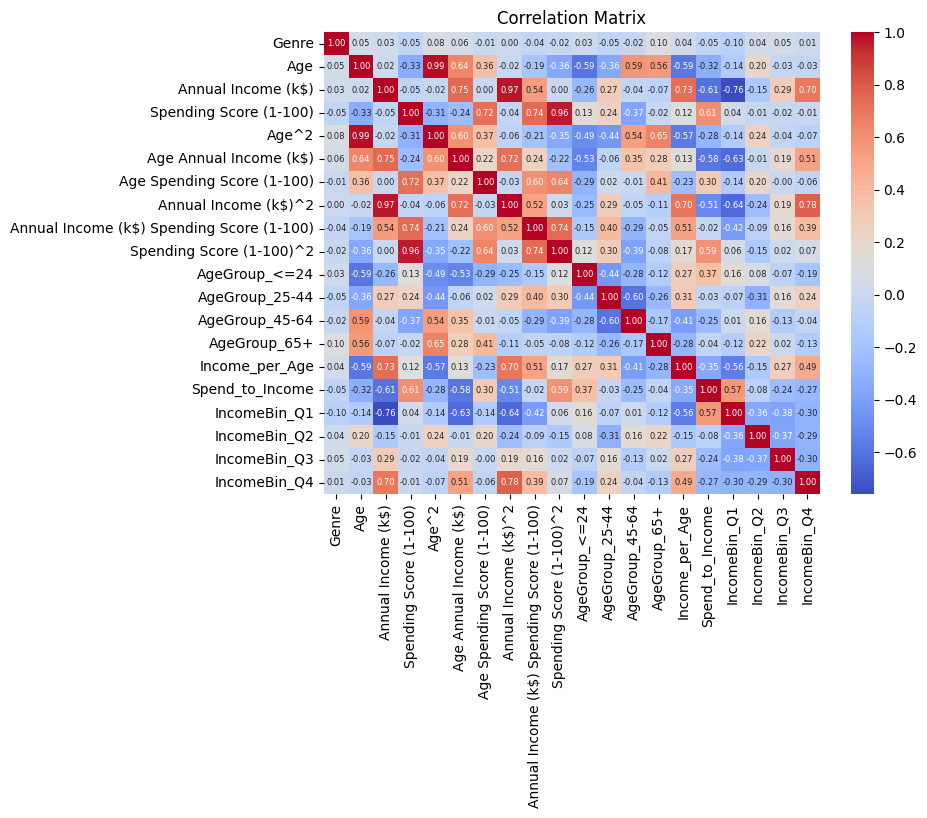

[[ 1.00000000e+00  5.33052936e-02  3.29091415e-02 -5.24477369e-02
   7.99735160e-02  5.62799389e-02 -5.27836442e-03  4.62744434e-03
  -4.15670118e-02 -1.58369442e-02  2.72631748e-02 -5.27147133e-02
  -2.20190558e-02  1.03574192e-01  3.90517324e-02 -5.41932767e-02
  -9.67046701e-02  4.20221493e-02  4.80305778e-02  7.45010139e-03]
 [ 5.33052936e-02  1.00000000e+00  1.88707285e-02 -3.28287919e-01
   9.85437253e-01  6.39215195e-01  3.63910624e-01 -1.56949834e-02
  -1.90195078e-01 -3.60383276e-01 -5.93964627e-01 -3.58905332e-01
   5.86703667e-01  5.56933363e-01 -5.86623534e-01 -3.20570515e-01
  -1.35344972e-01  1.99931763e-01 -3.11657642e-02 -3.44389475e-02]
 [ 3.29091415e-02  1.88707285e-02  1.00000000e+00 -5.20071886e-02
  -2.18516585e-02  7.51687397e-01  1.99680582e-04  9.72085430e-01
   5.42116840e-01  1.85369456e-03 -2.60028532e-01  2.72318292e-01
  -4.45079515e-02 -7.25762468e-02  7.31114352e-01 -6.07609610e-01
  -7.59940832e-01 -1.53095264e-01  2.90156375e-01  6.96011822e-01]
 [-5.24

In [78]:
# Feature Selection using Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 6}, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
print(correlation_matrix.to_numpy())

In [79]:
# 1) Filter: Variance and Correlation pruning
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Consider numeric columns only for clustering
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X_num = df[numeric_cols].copy()

# Near-zero variance removal (keep binary dummies)
vt = VarianceThreshold(threshold=1e-8)
X_vt = vt.fit_transform(X_num)
kept_by_variance = [c for c, keep in zip(numeric_cols, vt.get_support()) if keep]

# Correlation-based redundancy removal
corr = pd.DataFrame(X_vt, columns=kept_by_variance).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_threshold = 0.90
to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
kept_by_corr = [c for c in kept_by_variance if c not in to_drop]

print("Numeric columns:", numeric_cols)
print("Kept after variance:", kept_by_variance)
print("Dropped due to high correlation (>", corr_threshold, "):", to_drop)
print("Kept after correlation:", kept_by_corr)

Numeric columns: ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Age^2', 'Age Annual Income (k$)', 'Age Spending Score (1-100)', 'Annual Income (k$)^2', 'Annual Income (k$) Spending Score (1-100)', 'Spending Score (1-100)^2', 'Income_per_Age', 'Spend_to_Income']
Kept after variance: ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Age^2', 'Age Annual Income (k$)', 'Age Spending Score (1-100)', 'Annual Income (k$)^2', 'Annual Income (k$) Spending Score (1-100)', 'Spending Score (1-100)^2', 'Income_per_Age', 'Spend_to_Income']
Dropped due to high correlation (> 0.9 ): ['Age^2', 'Annual Income (k$)^2', 'Spending Score (1-100)^2']
Kept after correlation: ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Age Annual Income (k$)', 'Age Spending Score (1-100)', 'Annual Income (k$) Spending Score (1-100)', 'Income_per_Age', 'Spend_to_Income']


In [80]:
# 2) Wrapper: Greedy forward selection maximizing silhouette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations

def eval_subset(cols, k_range=range(2, 9)):
    if len(cols) == 0:
        return -1.0, None
    X = df[cols].to_numpy()
    Xs = StandardScaler().fit_transform(X)
    best_s, best_k = -1.0, None
    # Avoid trivial perfect separation for single feature by requiring k>=3 when dim==1
    k_candidates = [k for k in k_range if not (Xs.shape[1] == 1 and k <= 3)]
    for k in k_candidates:
        if k >= len(Xs):
            continue
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(Xs)
        if len(set(labels)) < 2:
            continue
        s = silhouette_score(Xs, labels, metric='euclidean')
        if s > best_s:
            best_s, best_k = s, k
    return best_s, best_k

remaining = list(set(kept_by_corr.copy() + kept_by_variance.copy())-set(to_drop))
selected = []
best_score = -1.0
improve_tol = 1e-4

# First step: pick the best group to avoid degenerate 1D solutions
if len(remaining) >= 6:
    group_scores = []
    for f1, f2, f3 in combinations(remaining, 3):
        s, k = eval_subset([f1, f2, f3])
        group_scores.append((s, (f1, f2, f3), k))
    group_scores.sort(reverse=True)  # by score desc
    best_group_s, (f1_best, f2_best, f3_best), best_k = group_scores[0]
    selected = [f1_best, f2_best, f3_best]
    remaining = [f for f in remaining if f not in selected]
    best_score = best_group_s

while len(remaining) > 0:
    candidates = []
    for f in remaining:
        s, k = eval_subset(selected + [f])
        candidates.append((s, f, k))
    candidates.sort(reverse=True)  # sort by score desc
    top_s, top_f, top_k = candidates[0]
    if top_s > best_score + improve_tol or len(selected) < 7:
        selected.append(top_f)
        remaining.remove(top_f)
        best_score = top_s
        best_k = top_k
    else:
        break

print("Wrapper-selected features:", selected)
print("Best silhouette:", round(best_score, 4), "with k=", best_k)

Wrapper-selected features: ['Spend_to_Income', 'Annual Income (k$) Spending Score (1-100)', 'Spending Score (1-100)', 'Genre', 'Annual Income (k$)', 'Age Annual Income (k$)', 'Income_per_Age']
Best silhouette: 0.3589 with k= 8


In [81]:
# 3) Embedded: RandomForest importances on pseudo labels (from KMeans) + aggregation
from sklearn.ensemble import RandomForestClassifier
from math import ceil

# Use wrapper-selected features; fallback to kept_by_corr if empty
wrapper_selected = selected if len(selected) > 0 else []
filter_kept = kept_by_corr.copy()
base_feats = wrapper_selected if len(wrapper_selected) > 0 else filter_kept
if len(base_feats) == 0:
    print("No features available after filtering; please check preprocessing.")
else:
    # Determine k by best silhouette on the base features
    s_base, k_use = eval_subset(base_feats)
    if k_use is None:
        k_use = 5
    print("Using k=", k_use, "for pseudo labels (best silhouette:", round(s_base, 4), ")")
    # Pseudo labels via KMeans
    Xb = df[base_feats].to_numpy()
    Xb_s = StandardScaler().fit_transform(Xb)
    km = KMeans(n_clusters=k_use, n_init=10, random_state=42)
    y_pseudo = km.fit_predict(Xb_s)
    # Train RandomForest to rank features
    rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf.fit(Xb, y_pseudo)
    importances = rf.feature_importances_
    feat_importances = sorted(zip(base_feats, importances), key=lambda x: x[1], reverse=True)
    print("Feature importances (desc):")
    for f, w in feat_importances:
        print(f"  {f}: {w:.4f}")
    # Keep top-N by importance (N = max(2, ceil(len(base_feats)/2)))
    top_n = max(2, ceil(len(base_feats)/1.5))
    embedded_top = [f for f, _ in feat_importances[:top_n]]
    # Aggregate three methods
    filter_set = set(filter_kept)
    wrapper_set = set(wrapper_selected)
    embedded_set = set(embedded_top)
    final_union = sorted(filter_set | wrapper_set | embedded_set)
    final_intersection = sorted(filter_set & wrapper_set & embedded_set)
    final_majority = sorted([f for f in final_union if (int(f in filter_set) + int(f in wrapper_set) + int(f in embedded_set)) >= 2])
    print("\nFilter kept:", sorted(filter_set))
    print("Wrapper selected:", sorted(wrapper_set))
    print("Embedded top:", embedded_top)
    print("\nFinal (union):", final_union)
    print("Final (intersection):", final_intersection)
    print("Final (majority vote >=2):", final_majority)

Using k= 8 for pseudo labels (best silhouette: 0.3589 )


Feature importances (desc):
  Genre: 0.1743
  Income_per_Age: 0.1543
  Annual Income (k$): 0.1540
  Spend_to_Income: 0.1457
  Spending Score (1-100): 0.1387
  Annual Income (k$) Spending Score (1-100): 0.1248
  Age Annual Income (k$): 0.1082

Filter kept: ['Age', 'Age Annual Income (k$)', 'Age Spending Score (1-100)', 'Annual Income (k$)', 'Annual Income (k$) Spending Score (1-100)', 'Genre', 'Income_per_Age', 'Spend_to_Income', 'Spending Score (1-100)']
Wrapper selected: ['Age Annual Income (k$)', 'Annual Income (k$)', 'Annual Income (k$) Spending Score (1-100)', 'Genre', 'Income_per_Age', 'Spend_to_Income', 'Spending Score (1-100)']
Embedded top: ['Genre', 'Income_per_Age', 'Annual Income (k$)', 'Spend_to_Income', 'Spending Score (1-100)']

Final (union): ['Age', 'Age Annual Income (k$)', 'Age Spending Score (1-100)', 'Annual Income (k$)', 'Annual Income (k$) Spending Score (1-100)', 'Genre', 'Income_per_Age', 'Spend_to_Income', 'Spending Score (1-100)']
Final (intersection): ['Annua

In [82]:
df_final = df[final_intersection]
df_final.to_csv("Preprocessed_Data.csv", index=False)
df_final.head()

,Annual Income (k$),Genre,Income_per_Age,Spend_to_Income,Spending Score (1-100)
0,-1.866777,1,-1.137799,4.430747,1.190104
1,-1.825592,0,-1.158515,3.828132,1.032512
2,-1.784407,0,-1.322240,1.305295,-0.425212
3,-1.784407,0,-1.072825,3.477424,0.993114
4,-1.743222,0,-1.360152,-0.766272,-1.764743
